# Enforcing physical stellar intensity profiles
As with planet surfaces, we should require that stellar surfaces have non-negative intensities everywhere. But for most realistic applications, it makes sense to also require that the intensities monotonically decrease toward the limb. Stars get darker toward the limb because the limb probes regions higher up in the star's photosphere, which are cooler and therefore dimmer. In `starry`, we can efficiently enforce these two conditions using [Sturm's theorem](https://en.wikipedia.org/wiki/Sturm%27s_theorem). The `is_physical()` method checks if the map is non-negative and if the limb darkening is monotonic everywhere.

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import emcee
from tqdm import tqdm
import corner

In [2]:
def lnlikeSturm(p, map):
    """Compute the log likelihood using constraints based on Sturm's theorem."""
    # Set the coeffs
    map[:] = p
    
    # Place some very loose bounds
    if np.any(p < -2) or np.any(p > 2):
        return -np.inf
    
    # Determine if it is positive semi-definite and monotonically decreasing
    if map.is_physical():
        return 0
    else:
        return -np.inf


def compute(lmax=1, nsteps=10000, scale=1e-4, lnlike=lnlikeSturm):
    """Run MCMC to find the PSD regions of parameter space."""
    # Instantiate the map
    map = starry.Map(lmax)

    # Run MCMC
    ndim = lmax
    nwalk = ndim * 2
    p0 = [scale * np.random.randn(ndim) for k in range(nwalk)]
    sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike, args=[map])
    for i in tqdm(sampler.sample(p0, iterations=nsteps), total=nsteps):
        pass

    # Plot the corner plot
    labels = [r"$u_{%d}$" % l for l in range(1, lmax + 1)]
    samples = sampler.flatchain[np.where(sampler.flatlnprobability == 0)]
    fig = corner.corner(samples, labels=labels, bins=50);
    for ax in fig.axes:
        ax.xaxis.label.set_fontsize(20)
        ax.yaxis.label.set_fontsize(20)
    
    return sampler

Let's check out what the allowed parameter space for `u_1` and `u_2` is:

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 10000/10000 [00:02<00:00, 4960.90it/s]


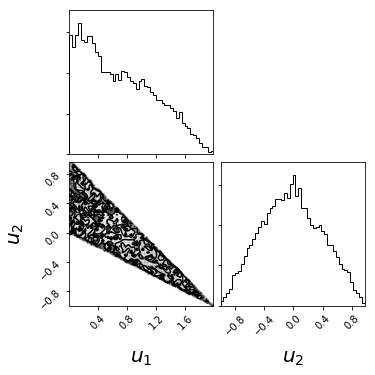

In [3]:
sampler = compute(lmax=2)

We can actually compare these to the simple, analytic expressions from [Kipping (2013)](https://arxiv.org/abs/1308.0009):

In [4]:
def lnlikeKipping(p, map):
    """Compute the log likelihood using the constraints from Kipping for quadratic limb darkening."""
    # Set the coeffs
    map[:] = p
    
    # Place some very loose bounds
    if np.any(p < -10) or np.any(p > 10):
        return -np.inf
    
    # Determine if it is positive semi-definite and monotonic
    u1 = p[0]
    u2 = p[1]
    if (u1 + u2 < 1) and (u1 > 0) and (u1 + 2 * u2 > 0):
        return 0
    else:
        return -np.inf

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 10000/10000 [00:01<00:00, 5212.65it/s]


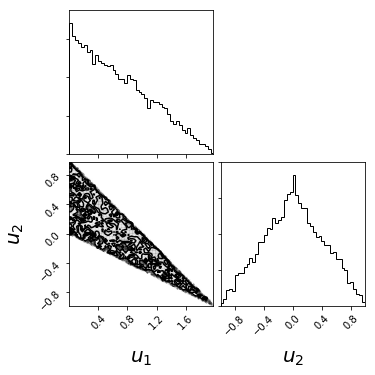

In [5]:
sampler = compute(lmax=2, lnlike=lnlikeKipping)

Nice. Now, just for fun, let's look at the parameter space for a higher order map (back to using Sturm's theorem now):

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 10000/10000 [00:02<00:00, 4094.85it/s]


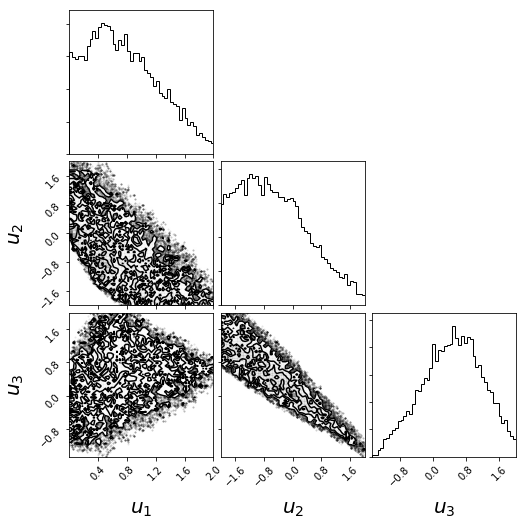

In [6]:
sampler = compute(lmax=3)

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
100%|██████████| 10000/10000 [00:02<00:00, 3582.04it/s]


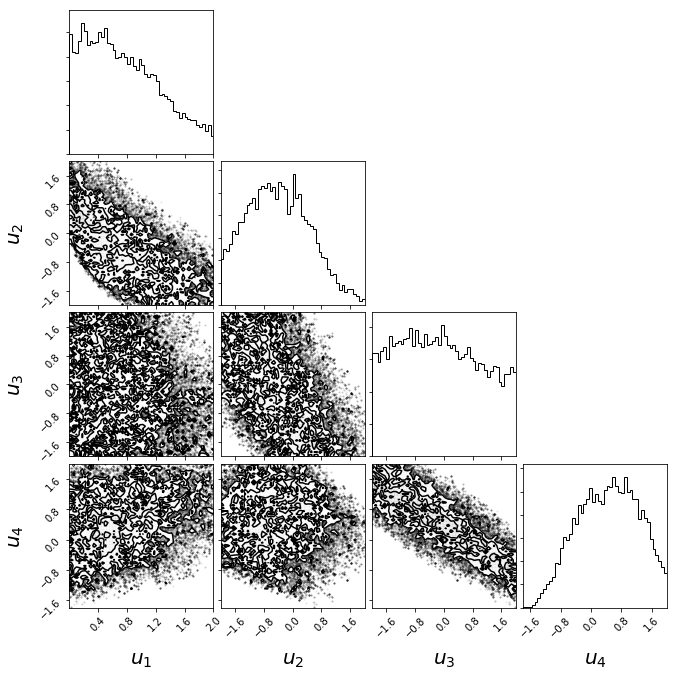

In [7]:
sampler = compute(lmax=4)